<a href="https://colab.research.google.com/github/vangarimahantesh/Data-analysis-python/blob/main/lab_exam_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Day  Orders
0     1     154
1     2     185
2     3     210
3     4     242
4     5     199
5     6     175
6     7     188
7     8     264
8     9     207
9    10     231
10   11     173
11   12     205
12   13     256
13   14     212
14   15     194
15   16     183
16   17     245
17   18     228
18   19     174
19   20     203
20   21     266
21   22     217
22   23     189
23   24     178
24   25     259
25   26     221
26   27     168
27   28     196
28   29     271
29   30     214

Files saved: daily_orders.csv, daily_orders.xlsx

Sample Mean: 210.23333333333332
Sample Variance: 1042.8057471264367

Probability(sim mean ≥ observed mean): 0.0
Probability(sim variance ≥ observed variance): 0.0

Z-test statistic: 26.93716556894746
Z-test p-value: 0.0
Poisson exact test p-value: 0.0

Chi-square variance p-value: 0.0
Bootstrap variance p-value: 0.0
LR test p-value: 5.551115123125783e-16


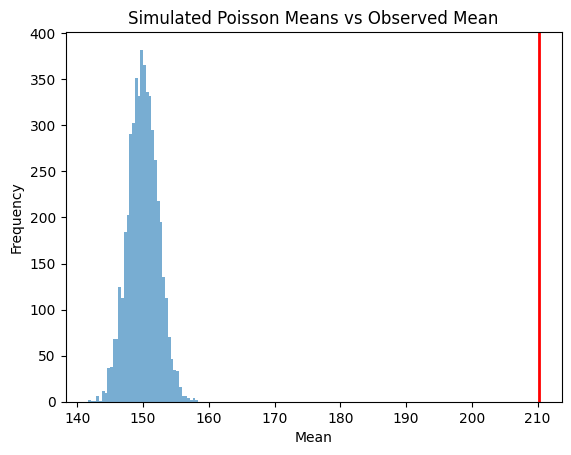

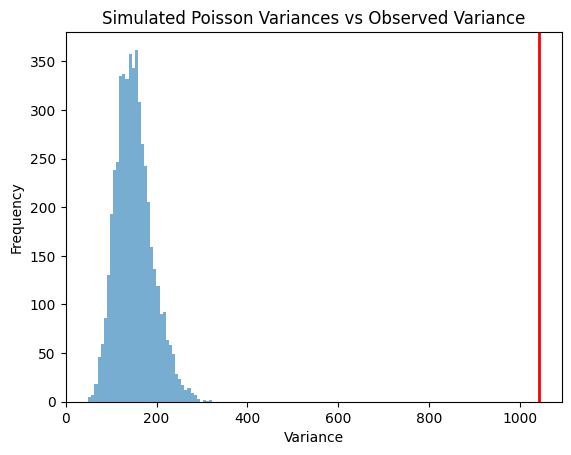

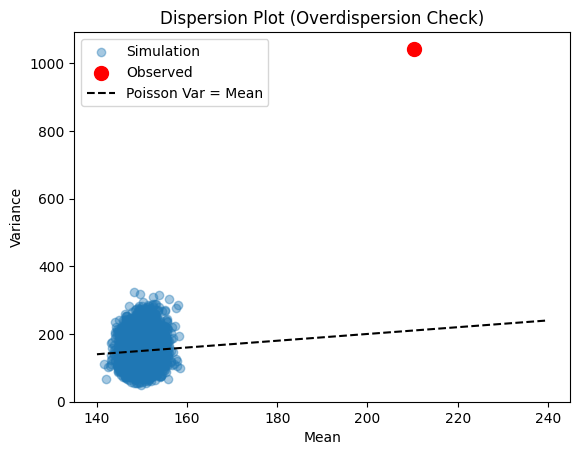


INTERPRETATION SUMMARY
-----------------------------
Mean significantly differs from 150 → mean increased.
Variance is MUCH higher than Poisson → strong overdispersion.
Negative Binomial fits significantly better → Poisson invalid.
-----------------------------


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from openpyxl import Workbook

np.random.seed(42)

# =====================================================
# A. CREATE DATASET (Given 30 Days)
# =====================================================
orders = [
    154,185,210,242,199,175,188,264,207,231,
    173,205,256,212,194,183,245,228,174,203,
    266,217,189,178,259,221,168,196,271,214
]

days = list(range(1, 31))

df = pd.DataFrame({"Day": days, "Orders": orders})

# Print dataset
print(df)

# Save CSV
df.to_csv("daily_orders.csv", index=False)

# Save Excel
wb = Workbook()
ws = wb.active
ws.title = "Daily Orders"
ws.append(["Day", "Orders"])
for d, o in zip(days, orders):
    ws.append([d, o])
wb.save("daily_orders.xlsx")

print("\nFiles saved: daily_orders.csv, daily_orders.xlsx")


# =====================================================
# B. SUMMARY STATISTICS
# =====================================================
sample_mean = np.mean(orders)
sample_var = np.var(orders, ddof=1)

print("\nSample Mean:", sample_mean)
print("Sample Variance:", sample_var)


# =====================================================
# C. SIMULATE 5000 MONTHS OF Poisson(150)
# =====================================================
sim = np.random.poisson(150, size=(5000, 30))
sim_means = sim.mean(axis=1)
sim_vars = sim.var(axis=1, ddof=1)

prob_mean_ge = np.mean(sim_means >= sample_mean)
prob_var_ge = np.mean(sim_vars >= sample_var)

print("\nProbability(sim mean ≥ observed mean):", prob_mean_ge)
print("Probability(sim variance ≥ observed variance):", prob_var_ge)


# =====================================================
# D. HYPOTHESIS TESTING – MEAN
# =====================================================

# Z-test for Poisson mean
lambda0 = 150
z_stat = (sample_mean - lambda0) / np.sqrt(lambda0 / 30)
p_z = 2 * (1 - st.norm.cdf(abs(z_stat)))

print("\nZ-test statistic:", z_stat)
print("Z-test p-value:", p_z)

# Poisson exact test
total_obs = int(sample_mean * 30)
p_exact = 2 * min(
    st.poisson.cdf(total_obs, 150*30),
    1 - st.poisson.cdf(total_obs - 1, 150*30)
)
print("Poisson exact test p-value:", p_exact)


# =====================================================
# E. VARIANCE TESTS
# =====================================================

# Chi-square test
chi_stat = (30 - 1) * sample_var / lambda0
p_chi = 1 - st.chi2.cdf(chi_stat, df=29)
print("\nChi-square variance p-value:", p_chi)

# Bootstrap variance test
boot_vars = []
for i in range(5000):
    b = np.random.poisson(150, size=30)
    boot_vars.append(np.var(b, ddof=1))
boot_vars = np.array(boot_vars)
p_boot = np.mean(boot_vars >= sample_var)

print("Bootstrap variance p-value:", p_boot)

# Likelihood Ratio Test (Poisson vs NB)
def pois_ll(data, lam):
    return np.sum(st.poisson.logpmf(data, lam))

def nb_ll(data, r, p):
    return np.sum(st.nbinom.logpmf(data, r, p))

lam_hat = sample_mean
ll_pois = pois_ll(orders, lam_hat)

theta = (sample_var - sample_mean) / sample_mean**2
r_nb = 1 / theta
p_nb = r_nb / (r_nb + lam_hat)

ll_nb = nb_ll(orders, r_nb, p_nb)

LR = 2 * (ll_nb - ll_pois)
p_lr = 1 - st.chi2.cdf(LR, df=1)

print("LR test p-value:", p_lr)


# =====================================================
# F. VISUALIZATIONS
# =====================================================

# 1. Distribution of simulated means
plt.hist(sim_means, bins=40, alpha=0.6)
plt.axvline(sample_mean, color="red", linewidth=2)
plt.title("Simulated Poisson Means vs Observed Mean")
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.show()

# 2. Distribution of simulated variances
plt.hist(sim_vars, bins=40, alpha=0.6)
plt.axvline(sample_var, color="red", linewidth=2)
plt.title("Simulated Poisson Variances vs Observed Variance")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.show()

# 3. Dispersion plot
plt.scatter(sim_means, sim_vars, alpha=0.4, label="Simulation")
plt.scatter(sample_mean, sample_var, color="red", label="Observed", s=100)
plt.plot([140, 240], [140, 240], 'k--', label="Poisson Var = Mean")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Dispersion Plot (Overdispersion Check)")
plt.legend()
plt.show()


# =====================================================
# G. INTERPRETATION
# =====================================================
print("\nINTERPRETATION SUMMARY")
print("-----------------------------")

if p_z < 0.05:
    print("Mean significantly differs from 150 → mean increased.")
else:
    print("Mean does NOT significantly differ from 150.")

if p_boot < 0.05:
    print("Variance is MUCH higher than Poisson → strong overdispersion.")
else:
    print("Variance consistent with Poisson.")

if p_lr < 0.05:
    print("Negative Binomial fits significantly better → Poisson invalid.")
else:
    print("No strong evidence against Poisson.")

print("-----------------------------")
